# Modelling the future resident population

AIM: extrapolate from the past data, the future resident population in Italy by age distribution, till year 2100.

I'm assuming a model like:

$ p(a=0,y) = br(y) = bp_{18:45}(y) * p(a=18:45,y) $

$ p(a,y) = p(a-1,y-1) * gpr(a, y-1) + nmb(a, y-1) $

$ p(a=100+, y) = p(a=99,y-1) * pgr(a, y-1) + p(a=100,y-1) *  pgr_{100+}(a, y-1) $

Where:
- $p(a, y)$ is the resident population of age $a$ in year $y$
- $br(y)$ is the annual new births in year $y-1$.
- $bp_{18:45}(y)$ is the  "birth propagation" i.e., the fraction of people in their 18-45 years old group that will have children that year.
- $bp_{18:45}(y)$ can be related to the fertility rate as $fr(y)=\frac{(45-18)*br(y)}{2}$, where the factor 2 assumes an equal population of men and women.
- $pgr(a, y)$ is the annual population growth rate in year $y$ which should be negative 
- $nmg(a, y)$ is the *Net Migration Balance*, positive for more people immigrating than emigrating
- $pgr_{100+}(a, y)$ is the annual population growth rate for the 100+ aged group

~~I will need to make some assumptions:~~
1. ~~no significant new migrations~~
2. ~~the $sr$ follows a linear trend w.r.t. the years (e.g., improve in care and technology), overlooking heat waves and covid that should be just weighed in the linear regression~~
3. ~~for $br$ I need to explore the previous trend and make some extrapolation, likely linear, and later try to use the $bp_{18:45}bp_{18:45}$ approach~~

These were my assumptions in April 2023, now I can do better!

- I will make 3 scenarios for the fertility rate (growing, constant, decreasing)
- I will get the data of death to decouple it from the immigration balance
- I will make 3 scenarios for the Net Migration Balance: no more migration from next year, constant migration, migration 5x higher in 2100
- for the $pgr$ of older people I will fit a decaying model instead of a linear one (so that it nevers reaches zero and gets, unreasonally, positive)
- I will combine these 3x3=9 scenarios and see the results

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas_datareader import wb # https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#world-bank Italian data are probably copied from ISTAT anyway
from copy import deepcopy

import plotly.io as pio
pio.renderers.default = 'notebook'

pd.options.plotting.backend = "plotly"

def get_colors(n, cmap_name="rainbow"):
    """Get colors for px colors_discrete argument, given the number of colors needed, n."""
    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i) for i in np.linspace(0, 1, n)]  # Generate colors
    colors_str = [f"rgba({int(color[0]*250)}, {int(color[1]*250)}, {int(color[2]*250)}, 1.0)" for color in colors]
    return colors_str

In [3]:
# Recover data from Notebook#1
dfp=pd.read_csv("../data/1_population_by_age_year.csv", index_col=0)
print("Italiant total resident population by age and year of observation")
dfp.columns = dfp.columns.map(int)
display(dfp)
dfpp=pd.read_csv("../data/1_pgr_by_age_year.csv", index_col=0)
dfpp.columns = dfpp.columns.map(int)
print("Italiant resident population-growth-rate (pgr) by age and year of observation")
display(dfpp)

Italiant total resident population by age and year of observation


,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
age,,,,,,,,,,,,,,,,,,,,,
0,523007,535656,542323,558500,551127,556884,560700,570791,562322,553218,...,499940,482977,469956,455066,431007,414974,404956,400626,393920,380630
1,529233,526577,538020,545596,559067,552870,560028,563021,569963,561694,...,511448,499707,482975,470412,455746,436785,423269,407634,404252,397193
2,528131,533126,531043,540860,548487,560347,556146,562640,564317,569064,...,532895,510117,499100,482810,470813,457314,443571,425183,411247,407572
3,518790,530847,537507,535545,543768,550808,563000,559193,564536,565219,...,539900,531804,508569,498644,482946,471696,464239,444638,428451,414581
4,515957,522484,534064,542329,540131,545782,554754,565127,560899,565563,...,555647,539174,530684,507352,498240,483769,480475,464753,447374,431500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,16400,17254,17494,20055,21122,24346,25054,27290,28086,29780,...,18513,24270,37624,38707,39836,41447,40293,40802,40632,42037
97,10981,11797,11980,12758,14071,15356,17559,18179,20203,21305,...,14483,13246,17960,27307,28842,29302,29016,29171,28420,29371
98,6838,7643,7901,8505,8725,9888,10871,12349,12977,14740,...,12386,10142,9607,12695,19650,20560,20113,20528,19836,20214


Italiant resident population-growth-rate (pgr) by age and year of observation


,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,
1,0.006826,0.004413,0.006035,0.001015,0.003163,0.005646,0.004139,-0.001451,-0.001117,-0.002708,...,-0.001351,-0.000466,-0.000004,0.000970,0.001494,0.013406,0.019989,0.006613,0.009051,0.008309
2,0.007356,0.008481,0.005279,0.005299,0.002290,0.005925,0.004664,0.002302,-0.001577,-0.001337,...,-0.001912,-0.002602,-0.001215,-0.000342,0.000852,0.003441,0.015536,0.004522,0.008863,0.008213
3,0.005143,0.008218,0.008478,0.005377,0.004232,0.004735,0.005479,0.003370,0.001598,-0.001633,...,-0.001016,-0.002047,-0.003035,-0.000914,0.000282,0.001875,0.015143,0.002405,0.007686,0.008107
4,0.007120,0.006060,0.008971,0.008563,0.003704,0.007164,0.003778,0.003051,0.001819,0.000717,...,-0.000696,-0.001345,-0.002106,-0.002393,-0.000810,0.001704,0.018612,0.001107,0.006153,0.007116
5,0.007592,0.008182,0.006784,0.009140,0.006976,0.007593,0.005785,0.002272,0.002077,0.001547,...,-0.000265,-0.001139,-0.001593,-0.001824,-0.000461,0.001814,0.019739,-0.003728,0.005136,0.006853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.245960,-0.263653,-0.233332,-0.247680,-0.231303,-0.232070,-0.231649,-0.215476,-0.209066,-0.213524,...,-0.218621,-0.242551,-0.223514,-0.232952,-0.223105,-0.221649,-0.253108,-0.234357,-0.252341,-0.229925
96,-0.261482,-0.280408,-0.255955,-0.271404,-0.251054,-0.253212,-0.256484,-0.239686,-0.218188,-0.223668,...,-0.235916,-0.257548,-0.237470,-0.249195,-0.237238,-0.244812,-0.275944,-0.256252,-0.275140,-0.255350
97,-0.280671,-0.305668,-0.270721,-0.298379,-0.272986,-0.278773,-0.274407,-0.259692,-0.241437,-0.234520,...,-0.252490,-0.284503,-0.259992,-0.274213,-0.254863,-0.264434,-0.299925,-0.276028,-0.303466,-0.277146


In [4]:
# Reference years I will be using for the analysis
start_year = dfp.columns[0] # 2002
last_year = dfp.columns[-1] # 2023 (or later if updated)
end_year = 2100

print(f"First-last observation: Jan/{start_year} - Jan/{last_year}")
print(f"First-last prediction:  Jan/{last_year+1} - Jan/{end_year}")

First-last observation: Jan/2002 - Jan/2024
First-last prediction:  Jan/2025 - Jan/2100


> NOTE: these data consider the population of year $y$ as the population of January 1st of year $y$, while other analyisis consider "the population at year $y$" at the end of that year.

## 1. Extrapolate the future births

Check notebook `3_fertility` for the full investigation, here I'm just recalling the whole results as a function I will need later for the extrapolation.

Remember that I will assume 3 scenarios for fertility: (1) going up to 2.0 in 2100, (2) staying constant, and (3) going down to 0 in 2100.

In [19]:
# Values from previous analysis
LAST_OBSERVERD_FERTILITY_YEAR = 2023
LAST_OBSERVED_FERTILITY_VALUE = 1.17
SIGMOID_X0_M = 9.45830775e-02
SIGMOID_X0_Q = -1.59900266e+02
SIGMOID_K = -0.295516663172129
WOMEN_POP_RATIO = 0.5

def get_newborns_next_year(dfp, year, fertility_rate):
    """Fom population and fertility rate for a given year,
    get the number of newborns for the NEXT year (fist January of year+1)."""
    def constrained_sigmoid(x0, k):
        """Get sigmoid function, which is a cumsum of a distribution."""
        x = np.arange(17, 50+1)
        y = 1 / (1 + np.exp(-k * (x - x0)))
        y = y - y[0]
        y = y / y[-1]
        return y
    pop = dfp[year]
    mothers_potential = pop.loc[18:50].to_numpy() * WOMEN_POP_RATIO
    x0 = np.polyval([ SIGMOID_X0_M, SIGMOID_X0_Q], year)
    distrib = np.diff(constrained_sigmoid(x0, SIGMOID_K))
    print(mothers_potential*distrib)
    return sum(mothers_potential * distrib) * fertility_rate

fertility_rate = {}
m_coeff_scenario_1 = (2 - LAST_OBSERVED_FERTILITY_VALUE) / (end_year - LAST_OBSERVERD_FERTILITY_YEAR)
m_coeff_scenario_3 = (0 - LAST_OBSERVED_FERTILITY_VALUE) / (end_year - LAST_OBSERVERD_FERTILITY_YEAR)
for year in range(LAST_OBSERVERD_FERTILITY_YEAR, end_year+1):
    fertility_rate[year] = {
        "scenario-1": LAST_OBSERVED_FERTILITY_VALUE + m_coeff_scenario_1 * (year - LAST_OBSERVERD_FERTILITY_YEAR), # going to 2
        "scenario-2": LAST_OBSERVED_FERTILITY_VALUE, # constant
        "scenario-3": LAST_OBSERVED_FERTILITY_VALUE + m_coeff_scenario_3 * (year - LAST_OBSERVERD_FERTILITY_YEAR), # going to 0
    }

## 2. Extrapolate the future *Population Growth Rate* - $pgr(age, year)$
I'm now monitoring and extrapolating the change of population getting one year older, and that I generally call "population growth rate" `pgr`.

- The more the `pgr` is negative, the higher the probability to die (or emigrate) in that year
- `pgr` can be positive if the immigration/emigration balance is increasing the population
- linear trends are probaly not good for extrapolation, but can give me an initial look to the trend of `pgr` over the years
- I can expect positive `pgr` in younger population due to immigration mainly, and negative `pgr` in older population due to mortality more than emigration

Trend of population-growth-rate (pgr) by age group. Observations (black dots, X for the ones excluded from the fit), linear fit (red line), average (blue line).


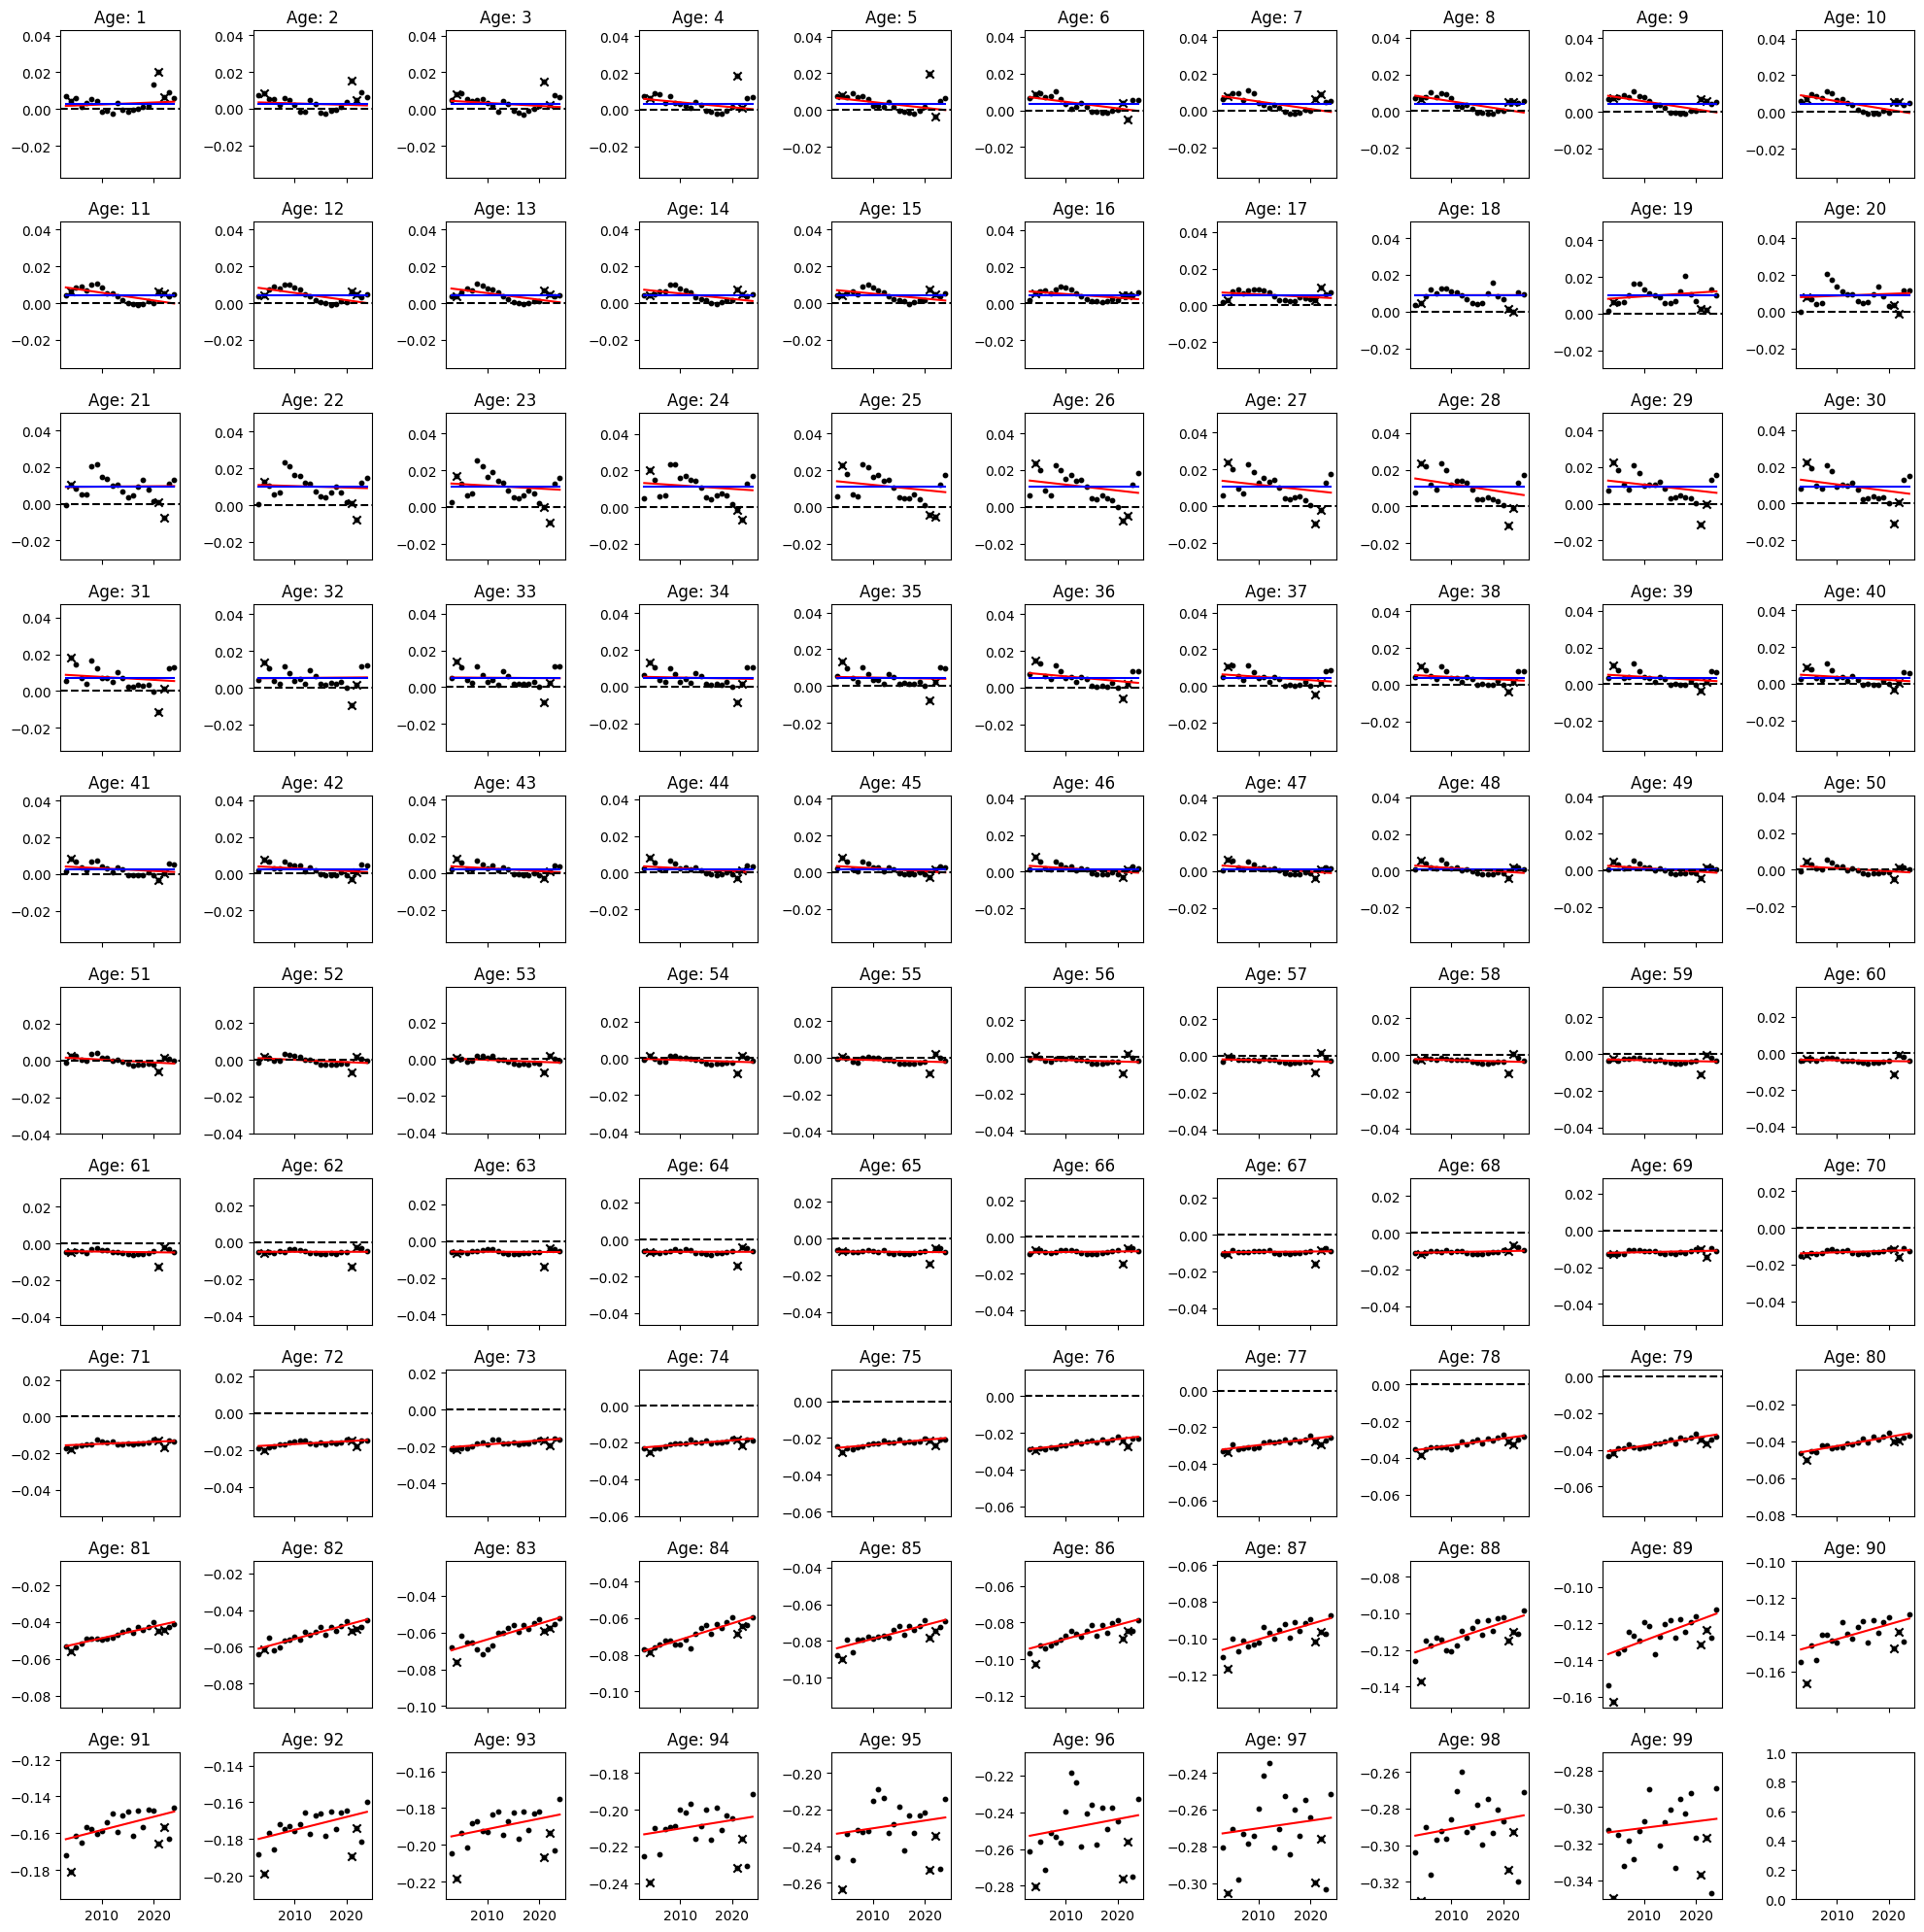

In [7]:
skip_years = [2004, 2021, 2022] # affected by heat wave and COVID
valid_years = [yr for yr in dfpp.columns if yr not in skip_years]

dfsr = dfpp.drop(columns=skip_years).copy()
# fit a linear trend for every age group: linear regression of the pgr from 1 to 99 (lr_sr_1_99)
lr_sr_1_99 = dfsr.apply(lambda x: np.polyfit(x.index, x, 1), axis=1)
# Plot coefficients for every age group and the linear trend
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharex=True)
for iplot, age in enumerate(dfsr.index):
    ax = axs.flatten()[iplot]
    ax.scatter(dfpp.columns, dfpp.loc[age].values, label=age, color="black", marker="o", s=10)
    ax.scatter(skip_years, dfpp[skip_years].loc[age], label=age, color="black", marker="x") # values not used for the fit (skip_years)
    ax.set_title(f"Age: {age}")
    ax.plot(dfsr.columns, np.polyval(lr_sr_1_99.loc[age], dfsr.columns), color="red") # linear fit
    if age<50: # average for the valid years
        ax.plot(dfsr.columns, [dfpp[valid_years].loc[age].mean()]*len(dfsr.columns), color="blue") # constant average
    ax.axhline(0, color="black", linestyle="--")
    y_avg = dfsr.loc[age].values.mean()
    y_margin = 0.04 # choose resonable values to fully show all the markers in the older ages
    ax.set_ylim(y_avg-y_margin, y_avg+y_margin) # note that I keep the same scale for all the plots, but transposed
plt.tight_layout()
print("Trend of population-growth-rate (pgr) by age group. Observations (black dots, X for the ones excluded from the fit), linear fit (red line), average (blue line).")
plt.show()

Results are quite rational:
- age < 50 (younger populat.): positive PGR due to a net balance between immigration - emigration. The trend is wavy.
- age >= 60 (older population): I see a clear negative SR, with a positive trend (i.e., less deadly) with the year, due to technology and care improvements

I can not distinguish between the effect of mortality and emigration, but I can assume that people mainly emigrate/immigrate when they are <50 years old:
> I need to revise this assumptions or my trands may be unrealisticly considering e.g., improving in care when it really is a decreasing immigration.

Therefore, I'm taking a pragmatic approach here:
- age < 50 - take some average PGR (positive) due to the immigration, and consider differen scenarios for future immigration
- 50<=age<60 - take some average rate (ca. zero, or slightly negative)
- age >= 60 - make a linear regression of a logaritmic transformation of the PGR to have a decaying trend which approaches (but never reaches) zero and positive (unreasonable) values

### 2.1 Making assumptions on the migration balance for <50

I'm assming:
- that PGR in 1-49 years old is only due to net immigration
- 3 scenarios: zero migration since next year, constant immigration, and increasing immigration (5x in 2100)

In [8]:
df_migr = pd.read_csv("data/5_migrants_by_age_year.csv", index_col=0)
df_migr.columns = df_migr.columns.map(int)
migr_avg = df_migr.mean(axis=1).astype(int)

AGE_WINDOW = (1, 49)
year_projection = list(range(last_year+1, end_year+1))
colors = get_colors(AGE_WINDOW[1]-AGE_WINDOW[0]+1)

migration_scenarios = {
    "migration: 0 from next year": 0,
    "migration: constant": 1,
    "migration: 5x in 2100": 5,
}

fig = go.Figure()
for i, age in enumerate(range(AGE_WINDOW[0],AGE_WINDOW[1]+1)):
    
    
    fig.add_trace(go.Scatter(
        x=df_migr.columns, 
        y=df_migr.loc[age], 
        mode='markers', 
        marker=dict(color=colors[i]), 
        name=str(age),
        hoverinfo='text',
        hovertext=[f"age: {age}, year of observation: {yr}" for yr in df_migr.columns]
    ))
    
    for migration_scenario, mx in migration_scenarios.items():
        avg_pgr = migr_avg[age]
        fig.add_trace(go.Scatter(
            x=[last_year+1, end_year], 
            y=[avg_pgr, avg_pgr*mx] if mx!=0 else [0, 0],
            mode='lines', 
            line=dict(color=colors[i]), 
            name=str(age),
            hoverinfo='text',
            hovertext=f"age: {age}, {migration_scenario}"
        ))
        
fig.update_layout(
    title=None,
    xaxis_title="Year",
    yaxis_title="Population by age group",
    showlegend=False,
    margin=dict(l=0, r=0, t=20, b=0),
    width=780,
    height=280,
)

fig.show()
fig.write_html(f"../../demographic_model_page/3_migration_balance_scenarios.html")


### 2.2 PGR for people older than 60 due to mortality and care improvements

In [9]:
FIT_AGE_WINDOW = (60, 99)
years_projection = list(range(start_year, end_year+1))

fit_coeff22 = {}
fit_polyn22 = {}
for age in range(FIT_AGE_WINDOW[0],FIT_AGE_WINDOW[1]+1):
    fit_coeff22[age] = np.polyfit(dfpp.columns, np.log(-dfpp.loc[age]), 1)
    fit_polyn22[age]= np.poly1d(fit_coeff22[age])

fig = go.Figure()
colors = get_colors(FIT_AGE_WINDOW[1]-FIT_AGE_WINDOW[0]+1)
for i, age in enumerate(range(FIT_AGE_WINDOW[0],FIT_AGE_WINDOW[1]+1)):
    fig.add_trace(go.Scatter(x=dfpp.columns, y=dfpp.loc[age], mode='markers', marker=dict(color=colors[i]), name=str(age)))
    fig.add_trace(go.Scatter(x=years_projection, y=-np.exp(fit_polyn22[age](years_projection)), line=dict(color=colors[i]), name=str(age)))

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Population Growth Rate ",
    showlegend=False,
    margin=dict(l=0, r=0, t=20, b=0),
    width=780,
    height=280,
)
fig.write_html("../../demographic_model_page/3_pgr_extrapolation.html")
print("PGR by age (color) for >60 older people: historical data and decaying exponential fit")
fig.show()

df2100 = pd.DataFrame({age: -np.exp(fit_polyn22[age]([2100])) for age in range(FIT_AGE_WINDOW[0],FIT_AGE_WINDOW[1]+1)}, index=["PGR in 2100"]).T
fig = px.scatter(
    df2100,
    x=df2100.index,
    y="PGR in 2100",
    color=colors,
    color_discrete_sequence=colors,
    title="PGR by age (color): projection for 2100"
).update_layout(
    title=None,
    xaxis_title="Age",
    yaxis_title="Population Growth Rate",
    showlegend=False,
    margin=dict(l=0, r=15, t=20, b=0),
    width=780,
    height=280,
)

print("Projected PGR rate in 2100, by age (color & x-axis)")
fig.show()

PGR by age (color) for >60 older people: historical data and decaying exponential fit


Projected PGR rate in 2100, by age (color & x-axis)


### 2.3 PGR for people aged 100+
This is a particular case because the group categorized as "100 or more" does not have any aging information.

In [10]:
df100 = dfp.loc[[99,100], range(start_year, 2020)].T
df100["sum"] = df100[99] + df100[100]
# make the survival rate the fraction of column "100" over the sum of columns "99" and "100" form the prvious year
df100["survival_rate"] = (df100[100] - df100["sum"].shift(1)) / df100["sum"].shift(1)
df100 = df100.drop(index=[start_year])

array([-1.31992076e-05, -3.33074749e-01])

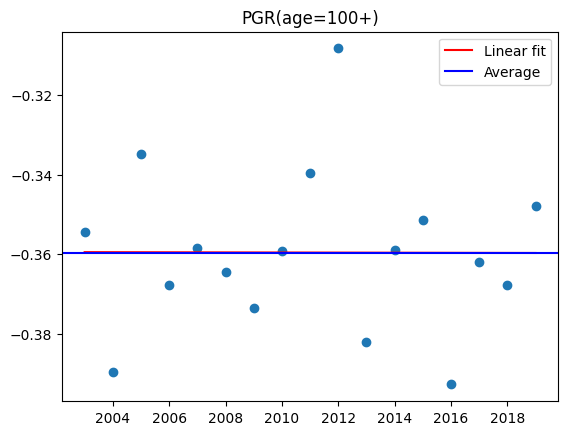

In [11]:
lr_pgr_100p = np.polyfit(df100.index, df100["survival_rate"], 1)
avg_pgr_100p = df100["survival_rate"].mean()
display(lr_pgr_100p)
# plot scatter and fit
plt.plot(df100.index, df100["survival_rate"], "o")
plt.plot(df100.index, np.polyval(lr_pgr_100p, df100.index), color="red", label="Linear fit")
plt.axhline(avg_pgr_100p, color="blue", label="Average")
plt.title("PGR(age=100+)")
plt.legend()
plt.show()

I can not spot any particular trend: therefore I will simply use an average value of the PGR of the 100+ group.

## Projection of the resident population till 2100
I now have all the coefficients to project the population from 2023 till 2100.
I will first project the PGR and later add the MIGRANTS.

In [12]:
pgr_proj = pd.DataFrame(columns=range(last_year+1, end_year+1), index=range(1, 100))

for age in range(1,50):
    pgr_proj.loc[age] = 0

for age in range(50, 60):
    pgr_proj.loc[age] = dfpp.loc[age].mean() 
    
for age in range(60, 100):
    pgr_proj.loc[age] = -np.exp(fit_polyn22[age](pgr_proj.columns))
    
pgr_proj.loc[100] = avg_pgr_100p

# round to 4 decimal digits
sr_proj = pgr_proj.astype(float).round(3)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sr_proj)

,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [13]:
subfigs = {
    "Historical": px.line(
        data_frame=dfpp,
        x=dfpp.index,
        y=dfpp.columns,
        color_discrete_sequence=get_colors(len(dfpp.columns)),
        title="Population change by age, on each year of observation",
    ),
     "Future Projection": px.line(
            data_frame=sr_proj,
            x=sr_proj.index,
            y=sr_proj.columns,
            color_discrete_sequence=get_colors(len(sr_proj.columns)),
            title="Population change by age, on each year of observation",
    )
}

fig = make_subplots(rows=1, cols=2, subplot_titles=list(subfigs), vertical_spacing=0) 

for i, ksubfig in enumerate(subfigs):
    subfig = subfigs[ksubfig]
    subfig.update_layout(
        title=ksubfig,
        xaxis_title="Age",
        yaxis_title="% Change in Population",
        yaxis_tickformat = ',.2%',
        legend_title_text="Year of observ.",
    )
    for trace in range(len(subfig["data"])):
        fig.append_trace(subfig["data"][trace], row=1, col=i+1)

    fig.update_xaxes(title="Age", range=[1, 99], row=1, col=i+1)
fig.update_yaxes(title="Pop. Growt Rate by Age", row=1, col=1)
fig.update_layout(
    title=None,
    showlegend=False,
    margin=dict(l=0, r=15, t=25, b=0),
    width=780,
    height=280,
)
print("Historical and projected-PGR-EXCLUDING-MIGRATION - color by observation year: early (violet), middle (cyan), late (red)")
fig.write_html("../../demographic_model_page/3_pgr.html")
fig.show()

Historical and projected-PGR-EXCLUDING-MIGRATION - color by observation year: early (violet), middle (cyan), late (red)


The curve of the survival rate is not very smooth in distant-future projections, but this is due to the fact that each age has a different linear trend. In particular we see that >95 years old, the yearly observations are more noisy and this noise gets amplified in the extrapolation. 

Overall I think this will need more investigation to have smoother curves, but I'm not sure the projected population will be that diferent. You can see the two trends:
- the age at which the non-survival rate starts to be significant (>2%) shifting from 73 to 87 in 80 years. This is not unresonable, as 80 years ago in Europe the life expectancy was about 15 years lower than today ([wikipedia](https://en.wikipedia.org/wiki/Life_expectancy)) - it could be due to much higher children mortality, though.
- the slope of the survival rate drop after this threshold getting less steeper, but only slightly.

In [14]:
# compute 9 scenarios
dfp_projs = {}

for fertility_scenario, fr in fr_projections.items():
    for migration_scenario, mx in migration_scenarios.items():
        label_scenario = fertility_scenario + " & " + migration_scenario
        print(f"Processing scenario -  {label_scenario}")
        dfpproj = dfp.copy()
        for y in range(last_year+1, end_year+1):
            bpy = fr.at[y]/(MOTHERS_AGE_WINDOW[1]-MOTHERS_AGE_WINDOW[0])*WOMEN_RATIO # birth propagation @ year, intended for the full population (men+women) in the age window
            dfpproj.loc[0, y] = bpy * dfpproj.loc[MOTHERS_AGE_WINDOW[0]:MOTHERS_AGE_WINDOW[1], y-1].sum()
            for age in range(1, 99+1):
                dfpproj.loc[age, y] = dfpproj.loc[age-1, y-1] * (1 + sr_proj.at[age, y])
                if age<50 and mx>0: # add migrants
                    coeff_m = (mx*migr_avg[age] - migr_avg[age]) / (end_year - (last_year+1)) #  m = (y2 - y1) / (x2 - x1)
                    coefF_q = migr_avg[age] - coeff_m * (last_year+1)  # b = y1 - m * x1
                    dfpproj.loc[age, y] +=  coeff_m * y + coefF_q 
            dfpproj.loc[100, y] = (dfpproj.loc[99, y-1] + dfpproj.loc[100, y-1]) * (1 + avg_pgr_100p)
        dfp_projs[label_scenario] = dfpproj.astype(int)
        
#plot last one to see if it makes sense
dfp_projs[label_scenario].filter(items=range(last_year-10, last_year+10), axis=1)

Processing scenario -  fertility: constant & migration: 0 from next year
Processing scenario -  fertility: constant & migration: constant
Processing scenario -  fertility: constant & migration: 5x in 2100
Processing scenario -  fertility: 2 in 2100 & migration: 0 from next year
Processing scenario -  fertility: 2 in 2100 & migration: constant
Processing scenario -  fertility: 2 in 2100 & migration: 5x in 2100
Processing scenario -  fertility: 0 in 2100 & migration: 0 from next year
Processing scenario -  fertility: 0 in 2100 & migration: constant
Processing scenario -  fertility: 0 in 2100 & migration: 5x in 2100


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
age,,,,,,,,,,,,,,,,,,,,
0,512140,499940,482977,469956,455066,431007,414974,404956,400626,393920,382068,363388,357100,351744,346996,342586,338200,334076,330106,326054
1,533916,511448,499707,482975,470412,455746,436785,423269,407634,404252,396272,383526,364924,358714,353435,348765,344433,340124,336078,332186
2,540449,532895,510117,499100,482810,470813,457314,443571,425183,411247,406841,397811,385147,366627,360499,355302,350715,346465,342238,338274
3,556034,539900,531804,508569,498644,482946,471696,464239,444638,428451,413942,408454,399510,386932,368498,362456,357345,352844,348680,344539
4,565065,555647,539174,530684,507352,498240,483769,480475,464753,447374,431424,415650,410253,401400,388913,370571,364619,359600,355190,351117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,19375,18513,24270,37624,38707,39836,41447,40293,40802,40632,43323,44261,46110,50657,48932,48945,50569,52403,54535,53289
97,17158,14483,13246,17960,27307,28842,29302,29016,29171,28420,30407,31755,32443,33799,37182,35916,35926,37168,38516,40138
98,15362,12386,10142,9607,12695,19650,20560,20113,20528,19836,20722,21741,22705,23229,24200,26659,25788,25794,26723,27693


In [15]:
# melt to a single dataframe
first = True
for label_scenario, dfpproj in dfp_projs.items():
    dfpprojmelt_ = dfpproj.reset_index().melt(id_vars="age", var_name="year", value_name="OBS_VALUE")
    dfpprojmelt_ = dfpprojmelt_.rename(columns={"OBS_VALUE": f"{label_scenario}"})
    if first:
        first = False
        dfpprojmelt = dfpprojmelt_
    else:
        dfpprojmelt = dfpprojmelt.merge(dfpprojmelt_, on=["age", "year"])

dfpprojmelt

,age,year,fertility: constant & migration: 0 from next year,fertility: constant & migration: constant,fertility: constant & migration: 5x in 2100,fertility: 2 in 2100 & migration: 0 from next year,fertility: 2 in 2100 & migration: constant,fertility: 2 in 2100 & migration: 5x in 2100,fertility: 0 in 2100 & migration: 0 from next year,fertility: 0 in 2100 & migration: constant,fertility: 0 in 2100 & migration: 5x in 2100
0,0,2002,523007,523007,523007,523007,523007,523007,523007,523007,523007
1,1,2002,529233,529233,529233,529233,529233,529233,529233,529233,529233
2,2,2002,528131,528131,528131,528131,528131,528131,528131,528131,528131
3,3,2002,518790,518790,518790,518790,518790,518790,518790,518790,518790
4,4,2002,515957,515957,515957,515957,515957,515957,515957,515957,515957
...,...,...,...,...,...,...,...,...,...,...,...
9994,96,2100,101163,126863,142102,101163,126863,142102,101163,126863,142102
9995,97,2100,75705,94273,104737,75705,94273,104737,75705,94273,104737
9996,98,2100,57278,70492,77583,57278,70492,77583,57278,70492,77583
9997,99,2100,41895,50830,55414,41895,50830,55414,41895,50830,55414


In [16]:
fig = px.line(
    dfpprojmelt, 
    x="age", 
    y=dfpprojmelt.columns, 
    title="Total population in Italy by age group (TOTAL)",
    animation_frame="year",
    markers=False,
)
fig.update_layout(
    xaxis_title="Age",
    yaxis_title="Population by age group",
    title=None,
    legend_title="Scenarios",
    margin=dict(l=10, r=10, t=10, b=10),
    width=780,
    height=420,
)
# put a highlighted area between 18 and 45
fig.add_vrect(x0=MOTHERS_AGE_WINDOW[0], x1=MOTHERS_AGE_WINDOW[1], fillcolor="LightSalmon", opacity=0.5, layer="below", line_width=0)
fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.write_html("../../demographic_model_page/3_final_population_by_age.html")
fig.show()

Slide the graph to note that, with this constant birth propagation (or fertility rate), the number of newborns drammatically decreases when the hill of 18-43 years old people flattens.

Let's now plot the projected total population:

In [17]:
first = True
for label_scenario, dfpproj in dfp_projs.items():
    dfpproj_sum_ = (
        pd.DataFrame(dfpproj.sum(), columns=[label_scenario])
        .reset_index()
        .rename(columns={"index": "Year"})
    )

    if first:
        first = False
        dfpproj_sum = dfpproj_sum_
    else:
        dfpproj_sum = dfpproj_sum.merge(dfpproj_sum_, on="Year")

dfpproj_sum

,Year,fertility: constant & migration: 0 from next year,fertility: constant & migration: constant,fertility: constant & migration: 5x in 2100,fertility: 2 in 2100 & migration: 0 from next year,fertility: 2 in 2100 & migration: constant,fertility: 2 in 2100 & migration: 5x in 2100,fertility: 0 in 2100 & migration: 0 from next year,fertility: 0 in 2100 & migration: constant,fertility: 0 in 2100 & migration: 5x in 2100
0,2002,56993270,56993270,56993270,56993270,56993270,56993270,56993270,56993270,56993270
1,2003,57186378,57186378,57186378,57186378,57186378,57186378,57186378,57186378,57186378
2,2004,57611990,57611990,57611990,57611990,57611990,57611990,57611990,57611990,57611990
3,2005,58044368,58044368,58044368,58044368,58044368,58044368,58044368,58044368,58044368
4,2006,58288996,58288996,58288996,58288996,58288996,58288996,58288996,58288996,58288996
...,...,...,...,...,...,...,...,...,...,...
94,2096,24397889,41627458,74923634,31918100,52422267,90671718,17902145,31924839,60031610
95,2097,23986466,41383184,75602241,31710724,52522911,91979634,17384984,31460753,60220740
96,2098,23578270,41138776,76290180,31509314,52630449,93316478,16872803,30996379,60409606
97,2099,23173964,40895384,76988787,31314603,52746195,94684143,16366276,30532895,60599422


In [18]:
fig = px.line(
    dfpproj_sum,
    x="Year",
    y=dfpproj_sum.columns,
    markers=True,
).update_layout(
    xaxis_title="Year",
    yaxis_title="Total Population",
    title=None,
    legend_title="Scenarios",
    margin=dict(l=0, r=15, t=20, b=0),
    width=780,
    height=380,
)
fig.write_html("../../demographic_model_page/3_final_total_population.html")
fig.show()

In [19]:
# save scenario labels as json
import json
with open("data/3_scenario_labels.json", "w") as f:
    json.dump(list(dfp_projs.keys()), f)

# save projections for each scenario
for label_scenario, dfpproj in dfp_projs.items():
    dfpproj.to_csv(f"data/3_population_projection_{label_scenario}.csv")

## Conclusions
- The nine scenarios predict an Italian population in 2100 between 15M to 100M depending on the assumptions
- The baseline scenario, constant fertility and migrations predicts a population of 40M in 2100
- My model of last year (2023) did not consider migration but a sligtly higher fertility rate, lending to 30M people in 2100, coherently with the refined model of this year

## Follow-up
- Get direct data on migration, deaths and maternity